In [ ]:
import random

from os import getcwd
from common.utils import * 

%matplotlib inline

figsize = (10, 8.5)
figsize_small = (5, 8.5)

input_dir = getcwd() + '/img/input_samples/'

### Cumulus test

In [ ]:
img = open_img(input_dir + '2.jpg')
img_fr = find_ft_2d(img)

img_shape = img.shape
y_size, x_size = img_shape
x_shift, y_shift = x_size // 2, y_size // 2
xx, yy = freq_numbers_2d(img_shape)
x, y = freq_mesh_2d(img_shape)

magn_raw = np.abs(img_fr)
magn = normalize(magn_raw)
magn_factor = normalize_psd(magn_raw, magn)
phase = np.angle(img_fr)
restored_img = find_ift_2d(magn_factor * magn * np.exp(1j * phase)).real

f, ax = show_images(img, np.log10(magn), phase, restored_img, figsize=figsize)
plt.show()

In [ ]:
phase_fr = find_ft_2d(phase)
phase_magn = np.abs(phase_fr)
phase_angle = np.angle(phase_fr)
restored_phase = find_ift_2d(phase_magn * np.exp(1j * phase_angle)).real

f, ax = show_images(np.log10(phase_magn), phase_angle, restored_phase, figsize=figsize)
plt.show()

In [ ]:
f_1 = show_surfaces(np.log10(magn), axes=(xx, yy))
# f_1.update_layout(scene = dict(zaxis = dict(range=[-5, 0])))
# plt.show()

In [ ]:
# f_2 = show_surfaces(phase[x_size // 2 - 10: x_size // 2 + 10, y_size // 2 - 10: y_size // 2 + 10], axes=(list(range(20)), list(range(20))))
f_2 = show_surfaces(phase, axes=(xx, yy))
# plt.show()

### Generating pseudo random phase trying to mimic same phase distribution along each axis

In [ ]:
new_phase_x = np.zeros(img_shape)
for i in range(x_size):
    new_phase_x[:, i] = surrogates(phase[:, i], 1)

new_phase_y = np.zeros(img_shape)
for i in range(y_size):
    new_phase_y[i, :] = surrogates(phase[i, :], 1)
    
# New phase and 1/f kernel
new_phase_sur = new_phase_x + new_phase_y 

# Restoring image using original phase and generated phase
restored_img = find_ift_2d(magn_factor * magn * np.exp(1j * new_phase_sur))

f, ax = show_images(new_phase_sur, restored_img, figsize=figsize)
plt.show()

In [ ]:
# Restoring image using 1/f kernel for magnitude and new phase 
# Results are equal to regular FFT syntesis

kernel = freq_pink_filter_2d(xx, yy)
kernel_magn_factor = normalize_psd(magn_raw, kernel)
restored_img = find_ift_2d(kernel_magn_factor * kernel * np.exp(1j * new_phase_sur))

f, ax = show_images(np.log10(kernel), restored_img, figsize=figsize)
plt.show()

### Restoring image using linearly changing phase

In [ ]:
initial_phase = [np.pi / 3, 2 * np.pi / 3, np.pi, np.pi / 2, 3 * np.pi / 2]
initial_phase += [-i for i in initial_phase]
whitenoise = np.random.normal(0, 1, img_shape)
whitenoise_fr = find_ft_2d(whitenoise)
lin_random_phase = np.angle(whitenoise_fr)

width = 5
scale = 0.2
alpha_x = 1.4
alpha_y = 1.
step = 1

for i in range(-width, width + 1, step):
    initial_phase_x = random.choice(initial_phase)
    initial_phase_y = random.choice(initial_phase)
    phase_y = lin_phase(initial_phase_y, initial_phase_y + random.choice(initial_phase), y_size)
    phase_x = lin_phase(initial_phase_x, initial_phase_x + random.choice(initial_phase), x_size)
    lin_random_phase[y_shift + i, :] = phase_x
    lin_random_phase[:, x_shift + i] = phase_y
    

restored_img_fr = magn_factor * magn * np.exp(1j * lin_random_phase)
restored_img = find_ift_2d(restored_img_fr)

f, ax = show_images(lin_random_phase, restored_img, figsize=figsize)
plt.show()

In [ ]:
magn_factor = normalize_psd(magn_raw, kernel)
restored_img_fr = magn_factor * kernel * np.exp(1j * lin_random_phase)
restored_img = find_ift_2d(restored_img_fr)

f, ax = show_images(lin_random_phase, restored_img, figsize=figsize)
plt.show()

### 1D regression

In [ ]:
# Custom regression formulas

# y_log = np.log(y_vals)
# x_log = np.log(1 + x_vals)

# alpha = -2 * np.sum(y_log * x_log) / np.sum(x_log ** 2) 
# alpha

In [ ]:
# Approximation along Y-axis

alpha = 1.
dy = 1
factor_y = [1, 0.2, 0.2, 0.15, 0.25, 0.08]
const_y = [0.0019, 0.0008, 0.0015, 0.001, 0.0012, 0.0008]

y_vals = magn[x_size // 2 + dy, magn.shape[1] // 2:] 
x_vals = np.array(range(len(y_vals)))

w_y = factor_y[abs(dy)] * ((1 + abs(x_vals)) ** (-alpha) + const_y[abs(dy)])
# kernel = freq_pink_filter_2d(xx, yy, factor=1)
# kernel[magn.shape[0] // 2, :] = w

plt.plot(x_vals, w_y)
plt.plot(x_vals[1:], y_vals[1:])
plt.yscale('log')
plt.show()

In [ ]:
# Approximation along X-axis

alpha = 1.45
dx = 1
factor_x = [1, 1, 1, 1, 1, 1]
const_x = [0.00015, 0.00015, 0.00015, 0.00015, 0.00015, 0.00015]

y_vals = magn[magn.shape[0] // 2:, y_size // 2 + dx] 
x_vals = np.array(range(len(y_vals)))
w_x = factor_x[abs(dx)] * ((1 + abs(x_vals)) ** (-alpha) + const_x[abs(dx)])

plt.plot(x_vals, w_x)
plt.plot(x_vals[0:], y_vals[0:])
plt.yscale('log')
plt.show()

In [ ]:
# Approximation along Y = X
alpha1 = 1.8
alpha2 = 1.0

l = magn.shape[0] // 2
y_vals = np.zeros(l)

for i in range(l):
    y_vals[i] = magn[l + i, l + i]
x_vals = np.array(range(len(y_vals))) * 2 ** 0.5

y_log = np.log10(y_vals)
x_log = np.log10(1 + x_vals)

w_diag = (1 + abs(x_vals)) ** (-alpha1) + 0.02 * (1 + abs(x_vals)) ** (-alpha2)
# kernel[:, magn.shape[1] // 2] = w

plt.plot(x_vals, w_diag)
plt.plot(x_vals[1:], y_vals[1:])
plt.yscale('log')
plt.show()

In [ ]:
# Combined kernel with previous approximation results
width = 5
scale = 0.2
alpha_x = 1.4
alpha_y = 1.
step = 1

# kernel = freq_pink_filter_2d(xx, yy, factor=0.5)
kernel = fit_clement(xx, yy, alpha1, alpha2)
# kernel = np.zeros((x_size, y_size))

for i in range(-width, width + 1, step):
    w_y = factor_y[abs(i)] * ((1 + abs(yy)) ** (-alpha_y) + const_y[abs(i)])
    w_x = factor_x[abs(i)] * ((1 + abs(xx)) ** (-alpha_x) + const_x[abs(i)])
    kernel[y_shift + i, :] = w_x
    kernel[:, x_shift + i] = w_y
    
# kernel[magn.shape[0] // 2, :] = w_y 
# kernel[:, magn.shape[1] // 2] = w_x 
kernel = normalize(kernel)

f = show_surfaces(np.log10(kernel), axes=(xx, yy))
# f.update_layout(scene=dict(zaxis = dict(range=[-5, 0])))
# f.show()

In [ ]:
# Restring image using approximated kernel and original phase
restored_img_1 = find_ift_2d(kernel * np.exp(1j * phase)).real
a, b = lin_regression(restored_img_1, img)
restored_img_1 = a * restored_img_1 + b

# Restring image using approximated kernel and random phase
whitenoise = np.random.normal(0, 1, (y_size, x_size))
random_phase = np.angle(find_ft_2d(whitenoise))
kernel_magn_factor = normalize_psd(magn_raw, kernel)
restored_img_2 = find_ift_2d(kernel_magn_factor * kernel * np.exp(1j * random_phase)).real

# Restring image using approximated kernel and linear phase
restored_img_3 = find_ift_2d(kernel_magn_factor * kernel * np.exp(1j * lin_random_phase)).real

# plt.imshow(restored_img_1, cmap='gray', vmin=np.min(img), vmax=np.max(img))
f, ax = show_images(restored_img_1, restored_img_2, restored_img_3, figsize=figsize)
plt.show()

### 2D regression

In [ ]:
y_vals = magn
x_vals = freq_filter_2d(xx, yy)

y_log = np.log10(y_vals)
x_log = np.log10(1 + x_vals)

alpha = -2 * np.sum(y_log * x_log) / np.sum(x_log ** 2) 
kernel = freq_pink_filter_2d(xx, yy, factor=alpha / 2)
print(f"alpha = {alpha / 2}")

f = show_surfaces(np.log10(kernel), np.log10(magn), axes=(xx, yy))
# f.show()

In [ ]:
# Restoring image using approximated kernel and original phase 
kernel_magn_factor = normalize_psd(magn_raw, kernel)
restored_image_1 = find_ift_2d(kernel_magn_factor * kernel * np.exp(1j * phase)).real
a, b = lin_regression(restored_image_1, img)
restored_image_1 = a * restored_image_1 + b

# Restoring image using approximated kernel and random phase 
restored_image_2 = find_ift_2d(kernel_magn_factor * kernel * np.exp(1j * random_phase)).real

# Restoring image using approximated kernel and linear phase 
restored_image_3 = find_ift_2d(kernel_magn_factor * kernel * np.exp(1j * lin_random_phase)).real

f, ax = show_images(restored_image_1, restored_image_2, restored_image_3, vrange=(np.min(img), np.max(img)), 
                    figsize=figsize)
plt.show()

### New approach

In [ ]:
x_arr, y_arr = np.meshgrid(xx, yy)
window = normalize(1 - np.sqrt(x_arr ** 2 + y_arr ** 2))
window = window

windowed_img = window * img
window_ft = find_ft_2d(window)
windowed_img_ft = find_ft_2d(windowed_img)
  
magn_windowed = np.abs(windowed_img_ft)
magn_n = normalize(magn_windowed)
magn_l = np.log10(magn_n)
phase_windowed = np.angle(windowed_img_ft)
restored_img = find_ift_2d(magn_windowed * np.exp(1j * phase_windowed)).real

vmin = np.min(windowed_img)
vmax = np.max(windowed_img)

f, ax = show_images(windowed_img, np.log10(magn_windowed), phase_windowed, restored_img, 
                    figsize=figsize)
plt.show()

In [ ]:
windowed_img_ft = find_ft_2d(phase_windowed)
m = np.abs(windowed_img_ft)
a = np.angle(windowed_img_ft)

whitenoise = np.random.normal(0, 1, img_shape)
psd = m * m
restored_phase = find_ift_2d(psd ** 0.5 * np.abs(whitenoise) * np.exp(1j * a)).real

kernel = freq_pink_filter_2d(xx, yy, factor=0.5)
cloud_hf = find_ift_2d(magn_windowed * np.exp(1j * restored_phase)).real
a, b = lin_regression(cloud_hf, img)
cloud_hf = a * cloud_hf + b

f, ax = show_images(np.log10(m), restored_phase, cloud_hf, figsize=figsize)
plt.show()

In [ ]:
alpha1 = 1.8
alpha2 = 1.0
alpha_x = 1.4
alpha_y = 1.

whitenoise = np.random.normal(0, 1, img_shape)
whitenoise_fr = find_ft_2d(whitenoise)
kernel = fit_clement(xx, yy, alpha1, alpha2, eta=0.5)
cloud_lf = find_ift_2d(whitenoise_fr * kernel).real
a, b = lin_regression(cloud_lf, img)
cloud_lf = a * cloud_lf + b

f, ax = show_images(np.log10(kernel), cloud_hf + 0.001 * cloud_lf, figsize=figsize)
plt.show()

### Defining an angle between X-axis and ellipse

In [ ]:
weight_exp = 2
threshold = 9
width_x = 3
width_y = 0

# Removing lines along X-axis to get better angle estimation 
min_magn = np.min(magn_windowed)
fit_magn = np.log(magn_windowed / min_magn)
fit_no_clip = fit_magn

for w in range(-width_y, width_y):
    fit_magn[:, y_shift + w] = fit_magn[:, y_shift + width_y] * 0

for w in range(-width_x, width_x):
    fit_magn[x_shift + w, :] = fit_magn[x_shift + width_x, :]

# Clipping magnitude 
fit_magn = np.where(fit_magn < threshold, 0, fit_magn)
fit_magn_max = np.exp(np.max(fit_magn))
fit_magn = fit_magn / np.mean(fit_magn)

# Defining slope with regression
avg_xy = -np.sum(x * y * fit_magn ** weight_exp)
avg_y2 = np.sum(y * y * fit_magn ** weight_exp)
avg_z2 = np.sum(fit_magn ** weight_exp)
a = avg_xy / avg_y2
angle = np.arctan(-1 / a) * 180 / np.pi

# Defining STD along the lines with the found slopes
lperp2 = np.sum((x + a * y) ** 2 * fit_magn ** weight_exp) / avg_z2
lpara2 = np.sum((a * x - y) ** 2 * fit_magn ** weight_exp) / avg_z2
lperp = lperp2 ** 0.5
lpara = lpara2 ** 0.5

# Outputing results 
print(f'A = {a}')
print(f'Angle = {angle}')
print(f'Slope = {1 / a}')
print(f'l_perp = {lperp}')
print(f'l_para = {lpara}')
print(f'l_perp corrected = {lperp2 ** 0.5}')

# Defining lines with found slopes
y_line = np.linspace(0.1 * y_size, 0.9 * y_size)
x_line = -a * (y_line - y_shift) + x_shift
# y_line = np.linspace(-0.3 * y_size, 0.3 * y_size)
# x_line = -a * y_line

# Defining gaussian approximation of clipped magnitude
model_magn = np.exp(-(x + a * y) ** 2 / 2 / (lperp2) -(a * x - y) ** 2 / 2 / (lpara2))
# model_magn = model_magn / np.mean(model_magn)

# Plotting 
f, ax = show_images(fit_magn, model_magn)
ax[0].plot(x_line, y_line)
ax[1].plot(x_line, y_line)
plt.show()

# f = go.Figure()
# f.add_trace(go.Heatmap(x=xx, y=yy, z=fit_magn))
# f.add_trace(go.Scatter(x=x_line, y=y_line))
# f.update_yaxes(scaleanchor="x", scaleratio=1)
# f.show()

In [ ]:
f, ax = show_images(fit_magn, figsize=figsize_small)
# ax[0].plot(x_line_para, y_line_para)
# ax[0].plot(x_line_perp, y_line_perp, '--')
plt.show()

### Regression along lines

In [ ]:
max_line_len = int(max(img_shape) * 2 ** 0.5) + 1

# Parallel line
para_slope = -1 / a
x_line_para = np.linspace(0, x_size, x_size, endpoint=False)
y_line_para = para_slope * (x_line_para - x_size // 2) + y_size // 2

# Clipping arrays
x_line_para, y_line_para = clip_graph(x_line_para, y_line_para, x_max=x_size, y_max=y_size)

# Making arrays to have the same shape as original array
x_line_min, x_line_max = int(np.min(x_line_para)), int(np.max(x_line_para))
x_line_para = np.linspace(x_line_min, x_line_max, max_line_len, endpoint=False)
y_line_para = para_slope * (x_line_para - x_size // 2) + y_size // 2

# Perpendicular line 
perp_slope = -1 / para_slope
x_line_perp = np.linspace(0, x_size, x_size, endpoint=False)
y_line_perp = perp_slope * (x_line_perp - x_size // 2) + y_size // 2

# Clipping arrays
x_line_perp, y_line_perp = clip_graph(x_line_perp, y_line_perp, x_max=x_size, y_max=y_size)
x_line_min, x_line_max = int(np.min(x_line_perp)) + 1, int(np.max(x_line_perp))
x_line_perp = np.linspace(x_line_min, x_line_max, max_line_len, endpoint=False)
y_line_perp = perp_slope * (x_line_perp - x_size // 2) + y_size // 2

# Plotting
f, ax = show_images(magn_l, cmap='gray', figsize=figsize_small)
ax[0].plot(x_line_para, y_line_para)
ax[0].plot(x_line_perp, y_line_perp)

In [ ]:
#1D regression along para line ORIGINAL APPROACH 
x_indexes_para = np.around(x_line_para).astype(int)
y_indexes_para = np.around(y_line_para).astype(int)

x_vals_para = np.hypot(x_line_para - x_shift, y_line_para - y_shift)
y_vals_para = magn_n[y_indexes_para, x_indexes_para]

max_val = np.max(y_vals_para)
mid = find_index_by_val(y_vals_para, max_val)
x_vals_para = x_vals_para[mid:]
y_vals_para = y_vals_para[mid:]

# Regression variables
x_log_para = np.log(1 + x_vals_para)
y_log_para = np.log(y_vals_para)
alpha_para = -2 * np.sum(y_log_para * x_log_para) / np.sum(x_log_para ** 2) 
alpha_para = alpha_para / 2 

para_approx = (1 + np.linspace(0, np.max(x_vals_para), x_vals_para.size)) ** (-alpha_para)
# para_approx /= np.max(para_approx)

plt.plot(x_vals_para, y_vals_para)
plt.plot(x_vals_para, para_approx)
plt.yscale('log')

print(f'Mid = {mid}')
print(f'Fade para = {alpha_para}')
print(f'Arr max = {max_val}')

In [ ]:
plt.semilogx(x_vals_para, 10 * np.log10(para_approx))
plt.semilogx(x_vals_para, 10 * np.log10(y_vals_para))
plt.grid()

In [ ]:
#1D regression along para line NEW APPROACH 
line_mid = x_line_para.size // 2
x_indexes_para_n = np.around(x_line_para[line_mid:]) #.astype(int)
y_indexes_para_n = np.around(y_line_para[line_mid:]) #.astype(int)

x_vals_para_n = np.hypot(x_line_para - x_shift, y_line_para - y_shift)
x_vals_para_n = x_vals_para_n[line_mid:]
y_vals_para_n = get_slice(magn_n, y_indexes_para_n, x_indexes_para_n) # magn_n[y_indexes_para_n, x_indexes_para_n]

max_val = np.max(y_vals_para_n)
mid = find_index_by_val(y_vals_para_n, max_val)
x_vals_para_n = x_vals_para_n[mid:]
y_vals_para_n = y_vals_para_n[mid:]

# Regression variables
x_log_para_n = np.log(1 + x_vals_para_n)
y_log_para_n = np.log(y_vals_para_n)
alpha_para = -2 * np.sum(y_log_para_n * x_log_para_n) / np.sum(x_log_para_n ** 2) 
alpha_para = alpha_para / 2 

para_approx = (1 + np.linspace(0, np.max(x_vals_para_n), x_vals_para_n.size)) ** (-alpha_para)
# para_approx /= np.max(para_approx)

plt.plot(x_vals_para_n, y_vals_para_n)
plt.plot(x_vals_para_n, para_approx)
plt.yscale('log')

print(f'Mid = {mid}')
print(f'Fade para = {alpha_para}')
print(f'Arr max = {max_val}')

In [ ]:
#1D regression along perp line ORIGINAL APPROACH 
x_indexes_perp = np.around(x_line_perp).astype(int)
y_indexes_perp = np.around(y_line_perp).astype(int)

x_vals_perp = np.hypot(x_line_perp - x_shift, y_line_perp - y_shift)
y_vals_perp = magn_n[y_indexes_perp, x_indexes_perp]

max_val = np.max(y_vals_perp)
mid = find_index_by_val(y_vals_perp, max_val)
x_vals_perp = x_vals_perp[mid:]
y_vals_perp = y_vals_perp[mid:]

# Regression variables
x_log_perp = np.log(1 + x_vals_perp)
y_log_perp = np.log(y_vals_perp)
alpha_perp = -2 * np.sum(y_log_perp * x_log_perp) / np.sum(x_log_perp ** 2) 
alpha_perp = alpha_perp / 2 

perp_approx = (1 + np.linspace(0, np.max(x_vals_perp), x_vals_perp.size)) ** (-alpha_perp)
# perp_approx /= np.max(perp_approx)

plt.plot(x_vals_perp, y_vals_perp)
plt.plot(x_vals_perp, perp_approx)
plt.yscale('log')

print(f'Mid = {mid}')
print(f'Fade pero = {alpha_perp}')
print(f'Arr max = {max_val}')

In [ ]:
line_mid = x_line_perp.size // 2
x_indexes_perp_n = np.around(x_line_perp[line_mid:])
y_indexes_perp_n = np.around(y_line_perp[line_mid:])

x_vals_perp_n = np.hypot(x_line_perp - x_shift, y_line_perp - y_shift)
x_vals_perp_n = x_vals_perp_n[line_mid:]
y_vals_perp_n = get_slice(magn_n, y_indexes_perp_n, x_indexes_perp_n)

max_val = np.max(y_vals_perp_n)
mid = find_index_by_val(y_vals_perp_n, max_val)
x_vals_perp_n = x_vals_perp_n[mid:]
y_vals_perp_n = y_vals_perp_n[mid:]

# Regression variables
x_log_perp = np.log(1 + x_vals_perp_n)
y_log_perp = np.log(y_vals_perp_n)
alpha_perp = -2 * np.sum(y_log_perp * x_log_perp) / np.sum(x_log_perp ** 2) 
alpha_perp = alpha_perp / 2 

perp_approx = (1 + np.linspace(0, np.max(x_vals_perp_n), x_vals_perp_n.size)) ** (-alpha_perp)
# perp_approx /= np.max(perp_approx)

plt.plot(x_vals_perp_n, y_vals_perp_n)
plt.plot(x_vals_perp_n, perp_approx)
plt.yscale('log')

print(f'Mid = {mid}')
print(f'Fade para = {alpha_perp}')
print(f'Arr max = {max_val}')

### Defining best fit enumerating three parameters

In [ ]:
min_error = 10 ** 10
alpha_steps = 50
eta_steps = 50

alphas = list(np.linspace(1, 2, alpha_steps))
etas = list(np.linspace(0, 1, eta_steps))
slopes = list(np.linspace(0.9 * -1 / a, 1.1 * -1 / a, 10))
errors = np.zeros((alpha_steps, eta_steps))

power = 1
g = np.ones_like(img) # 0.5 * gaussian_new(x, y, max(lpara, lperp)) + 0.5
#gaussian(x, para_slope * y, lpara2_new ** 0.5) * gaussian(para_slope * x, -y, lperp2_new ** 0.5)
weight = g ** power

for k, slope in enumerate(slopes):
    print_progress_bar(k + 1, len(slopes), prefix = 'Progress:', suffix = 'Complete', length=50)
    for i, alpha in enumerate(alphas):
        for j, eta in enumerate(etas):
            my_fit = np.log10(fit_clement_new(xx, yy, alpha, eta=eta, slope=slope))
            error = rmse(magn_l, my_fit, weight, normalize=True)
            errors[i, j] = error
            
            if min_error > error:
                min_error = error
                min_params = (slope, alpha, eta)
                best_fit = my_fit
    
print(*min_params, min_error)

### Playground

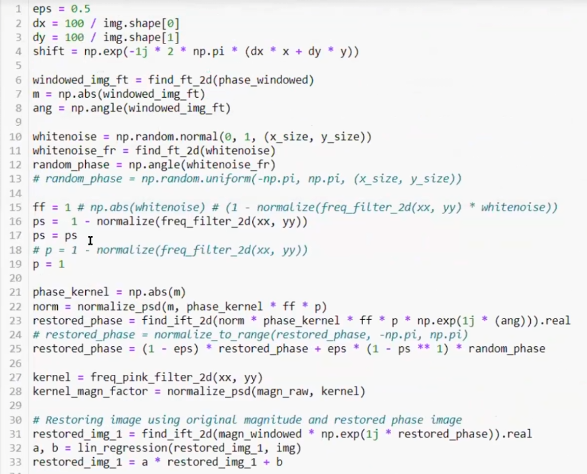
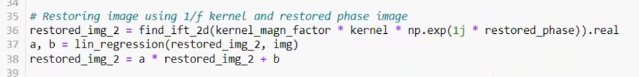

In [ ]:
eps = 0.5

phase_ft = find_ft_2d(phase_windowed)
m = np.abs(phase_ft)
ang = np.angle(phase_ft)

whitenoise = np.random.normal(0, 1, img_shape)
whitenoise_fr = find_ft_2d(whitenoise)
random_phase = np.angle(whitenoise_fr)

ff = 1
ps = normalize(freq_filter_2d(xx, yy))
p = 1

phase_kernel = np.abs(m)
norm = normalize_psd(m, phase_kernel * ff * p)
restored_phase = find_ift_2d(norm * phase_kernel * ff * p * np.exp(1j * ang)).real
restored_phase = (1 - eps) * restored_phase  + eps * random_phase

restored_kernel = fit_clement_new(xx, yy, alpha_perp, eps, para_slope)
restored_kernel_factor = normalize_psd(magn_raw, restored_kernel)
restored_img_3 = find_ift_2d(restored_kernel_factor * restored_kernel * np.exp(1j * restored_phase))

show_images(restored_img_3, img, vrange=(vmin, vmax))
# show_images(restored_img_3, img, restored_phase)

In [ ]:
x = np.linspace(-5, 5)
y_raw = 2 * np.linspace(-5, 5) 
y = y_raw + np.random.normal(0, 5, x.shape)

plt.plot(x, y_raw)
plt.plot(x, y)

In [ ]:
sum_x2 = np.sum(x * x)
sum_y2 = np.sum(y * y)
sum_xy = np.sum(x * y)

slope_x = sum_xy / sum_x2
slope_y = sum_xy / sum_y2

print(f'Slope x = {slope_x}')
print(f'Slope y = {slope_y}')

x_vals = np.linspace(-5, 5) 
y_vals = np.linspace(-5, 5) 

plt.plot(x_vals, slope_x * x_vals)
plt.plot(slope_y * x_vals, x_vals)
plt.plot(x, y)
# plt.plot(y, x)

In [ ]:
f, ax = show_images(x * y * fit_magn ** weight_exp, 
                    x * x * fit_magn ** weight_exp, 
                    y * y * fit_magn ** weight_exp)

In [ ]:
# PCA
indexes = fit_magn >= threshold
x, y = [], []

for row in range(indexes.shape[0]):
    for col in range(indexes.shape[1]):
        if indexes[row, col]:
            y.append(row)
            x.append(col)
            

x_centered = x - np.mean(x)
y_centered = y - np.mean(y)

# Create the centered matrix
data_centered = np.vstack([x_centered, y_centered])

# Compute the covariance matrix
cov_matrix = np.cov(data_centered)

# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort the eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[:, sorted_indices]

# The eigenvectors are now the directions of the axes of the ellipse,
# with the largest eigenvalue corresponding to the major axis.
major_axis = eigenvectors_sorted[:, 0]
minor_axis = eigenvectors_sorted[:, 1]

# Print the results
print(f"Major Axis: {major_axis}")
print(f"Minor Axis: {minor_axis}")

fig, ax = show_images(fit_magn)
ax[-1].plot([x_shift, x_shift + 300 * major_axis[0]], [y_shift, y_shift + 300 * major_axis[-1]])
ax[-1].plot([x_shift, x_shift + 300 * minor_axis[0]], [y_shift, y_shift + 300 * minor_axis[-1]])

In [ ]:
weight_exp = 2
threshold = 9
width_x = 3
width_y = 0
x, y = np.meshgrid(xx, yy)

# Removing lines along X-axis to get better angle estimation 
min_magn = np.min(magn_windowed[np.nonzero(magn_windowed)])
fit_magn = np.log(magn_windowed / min_magn)
fit_no_clip = fit_magn

for w in range(-width_y, width_y):
    fit_magn[:, y_shift + w] = fit_magn[:, y_shift + width_y] * 0

for w in range(-width_x, width_x):
    fit_magn[x_shift + w, :] = fit_magn[x_shift + width_x, :]

# Clipping magnitude 
fit_magn = np.where(fit_magn < threshold, 0, fit_magn)
fit_magn = fit_magn / np.mean(fit_magn)

# Defining slope with regression
avg_xy = np.sum(x * y * fit_magn ** weight_exp)
avg_x2 = np.sum(x * x * fit_magn ** weight_exp)
avg_y2 = np.sum(y * y * fit_magn ** weight_exp)
slope = avg_xy / avg_y2
# slope = avg_xy / avg_x2

# Outputing results 
print(f'Slope = {slope}')

# Defining lines with found slopes
y_line = np.linspace(-0.3 * y_size, 0.3 * y_size)
x_line = slope * y_line
#x_line = np.linspace(-0.3 * x_size, 0.3 * x_size)
#y_line = slope * x_line

f = go.Figure()
f.add_trace(go.Heatmap(x=xx, y=yy, z=fit_magn, colorscale='greys_r'))
f.add_trace(go.Scatter(x=x_line, y=y_line))
f.update_yaxes(scaleanchor="x", scaleratio=1)
f.update_layout(width=500, height=500)
f.show()

In [ ]:
# Defining STD along the lines with the found slopes
lperp2 = np.sum((x + a * y) ** 2 * fit_magn ** weight_exp) / avg_z2
lpara2 = np.sum((a * x - y) ** 2 * fit_magn ** weight_exp) / avg_z2
lperp = lperp2 ** 0.5
lpara = lpara2 ** 0.5

# Outputing results 
print(f'A = {a}')
print(f'Angle = {angle}')
print(f'Slope = {1 / a}')
print(f'l_perp = {lperp}')
print(f'l_para = {lpara}')
print(f'l_perp corrected = {lperp2 ** 0.5}')

# Defining lines with found slopes
y_line = np.linspace(0.1 * y_size, 0.9 * y_size)
x_line = -a * (y_line - y_shift) + x_shift
# y_line = np.linspace(-0.3 * y_size, 0.3 * y_size)
# x_line = -a * y_line

# Defining gaussian approximation of clipped magnitude
model_magn = np.exp(-(x + a * y) ** 2 / 2 / (lperp2) -(a * x - y) ** 2 / 2 / (lpara2))
# model_magn = model_magn / np.mean(model_magn)

# Plotting 
f, ax = show_images(fit_magn, model_magn, (x + a * y) ** 2 * fit_magn ** weight_exp, (a * x - y) ** 2 * fit_magn ** weight_exp)
ax[0].plot(x_line, y_line)
ax[1].plot(x_line, y_line)
plt.show()

In [ ]:
def gaussian(x_vals, y_vals, std):
    arg = x_vals + y_vals 
    exp = np.exp(-arg ** 2 / (2 * std ** 2))
    return exp


def gaussian_new(x_vals, y_vals, std):
    exp = np.exp(-(x_vals ** 2 + y_vals ** 2) / (2 * std ** 2))
    return exp


def fit(x_freq, y_freq, alpha1, eta=0.1, angle=1):
    x, y = np.meshgrid(x_freq, y_freq)
    f = np.hypot(x, y)
    fp = abs(y - angle * x)
    f = np.sqrt((1 - eta) * f ** 2 + eta * fp ** 2)
    f = 1 / ((1 + abs(f)) ** alpha1)
    return f

In [ ]:
lperp2 = np.sum((x + a * y) ** 2 * fit_magn ** weight_exp) / avg_z2
lpara2 = np.sum((a * x - y) ** 2 * fit_magn ** weight_exp) / avg_z2
lpara2_new = np.sum((para_slope * x - y) ** 2 * fit_magn ** weight_exp) / avg_z2
lperp2_new = np.sum((perp_slope * x - y) ** 2 * fit_magn ** weight_exp) / avg_z2

perp_my = np.exp(-(x + para_slope * y) ** 2 / 2 / lpara2_new)
para_my = np.exp(-(para_slope * x - y) ** 2 / 2 / lperp2_new)

z1 = np.exp(-(x + a * y) ** 2 / 2 / (lperp2))
z2 = np.exp(-(a * x - y) ** 2 / 2 / (lpara2))
z3 = np.exp(-(x + a * y) ** 2 / 2 / (lperp2) -(a * x - y) ** 2 / 2 / (lpara2))
z4 = gaussian_new(para_slope * x, -y, lperp2_new ** 0.5) * gaussian_new(x, para_slope * y, lpara2_new ** 0.5) 
z5 = np.exp(-(para_slope * x - y) ** 2 / 2 / (lpara2_new) -(perp_slope * x - y) ** 2 / 2 / (lperp2_new))

show_images(z3, z5)

In [ ]:
# Defining optimal alpha and eta values that minimize approximation error 

# Factor that represents how stretched ellipse along its major axis
stretch_factor = (lpara2 / lperp2) ** 0.5
magn_n = normalize(magn_windowed)
magn_l = np.log10(magn_n)
std = np.std(magn_windowed)

print(f'Stretch = {stretch_factor}', f'\nSTD = {std}')

In [ ]:
# Original stretched gaussian

perp_gaussian = np.exp(-(a * x - y) ** 2 / 2 / (lpara2))
para_gaussian = np.exp(-(x + a * y) ** 2 / 2 / (lperp2))

perp_my = np.exp(-(perp_slope * x - y) ** 2 / (2 * lpara2))
para_my = np.exp(-(x + perp_slope * y) ** 2 / (2 * lperp2))

"""
f, ax = show_images(perp_my, para_my, perp_my * para_my, figsize=figsize)
ax.flatten()[0].plot(x_line_para, y_line_para)
ax.flatten()[0].plot(x_line_perp, y_line_perp)
ax.flatten()[1].plot(x_line_para, y_line_para)
ax.flatten()[1].plot(x_line_perp, y_line_perp)
plt.show()
"""

print(1 / (lpara2 / lperp2) ** 0.5)

In [ ]:
g1 = gaussian_new(x, para_slope * y, lperp) 
g2 = gaussian_new(para_slope * x, -y, lperp)
g = np.exp(-(x **2 + y ** 2) / (2 * lpara2))
g_n = gaussian_new(x, y, max(lpara, lperp))

# show_images(g1, g2, g, g_n, model_magn)

In [ ]:
# Recreating stretched gaussian in a different manner 

lperp2_new = np.sum((para_slope * x - y) ** 2 * fit_magn ** weight_exp) / avg_z2
lpara2_new = np.sum((x + para_slope * y) ** 2 * fit_magn ** weight_exp) / avg_z2

# perp_my = np.exp(-(x + para_slope * y) ** 2 / 2 / lpara2_new)
# para_my = np.exp(-(para_slope * x - y) ** 2 / 2 / lperp2_new)

# f, ax = show_images(perp_my, para_my, perp_my * para_my, gaussian(x, para_slope * y, lperp) * gaussian(para_slope * x, -y, lperp), figsize=figsize)
# plt.plot()

print((lpara2_new / lperp2_new) ** 0.5)

In [ ]:
min_error = 10 ** 10
alpha_steps = 50
eta_steps = 50

angle = para_slope
alphas = list(np.linspace(1, 2, alpha_steps))
etas = list(np.linspace(0, 1, eta_steps))
errors = np.zeros((alpha_steps, eta_steps))

power = 1
g = 0.5 * gaussian_new(x, y, max(lpara, lperp)) + 0.5
#gaussian(x, para_slope * y, lpara2_new ** 0.5) * gaussian(para_slope * x, -y, lperp2_new ** 0.5)
weight = g ** power

for i, alpha in enumerate(alphas):
    print_progress_bar(i + 1, alpha_steps, prefix = 'Progress:', suffix = 'Complete', length=50)
    for j, eta in enumerate(etas):
        my_fit = np.log10(fit_clement_new(xx, yy, alpha, eta=eta, angle=angle))
        error = rmse(magn_l, my_fit, weight, normalize=True)
        errors[i, j] = error
    
        if min_error > error:
            min_error = error
            min_params = (alpha, eta)
            best_fit = my_fit
    
print(*min_params, min_error)

In [ ]:
stretch = 1 - (alpha_para / alpha_perp)
print(stretch)

In [ ]:
aa = np.log(fit_clement_new(xx, yy, 1, 0))
bb = np.log(fit_clement_new(xx, yy, 1, 1))

f, ax = plt.subplots(1, 1)
ax.contour(aa)
ax.contour(bb)
plt.gca().set_aspect('equal')


In [ ]:
# show_surfaces((etas, alphas, errors))

f, ax = show_images(errors)
ax[-1].scatter([50 * 0.08163265306122448], [50 * (1.5510204081632653 - 1)])
ax[-1].scatter([50 * 0.09926537681351011], [50 * (alpha_perp - 1)])

In [ ]:
my_fit = np.log10(fit_clement_new(xx, yy, 1.5912427219379994, eta=0.09030864630077595, angle=angle))
error = rmse(magn_l, my_fit)

show_surfaces(my_fit, axes=(xx, yy))

In [ ]:
# Parameters values that minimizes RMSE vs different weighting fuctions 

# alpha / eta / rmse / weighting function used 
1.530612244897959 0.1836734693877551 0.3170742184535750 - stretch_factor gaussian, lperp2_new, lpara2_new, power 1/16
1.510204081632653 0.3061224489795918 0.3141849150420232 - stretch_factor gaussian, lperp2_new, lpara2_new, power 1/8
1.510204081632653 0.4285714285714286 0.3059434597361637 - stretch_factor gaussian, lperp2_new, lpara2_new, power 1/4
1.489795918367347 0.5102040816326531 0.2980129494208664 - stretch_factor gaussian, lperp2_new, lpara2_new, power 1/2
1.551020408163265 0.0816326530612245 0.3101641380512348 - stretch_factor gaussian, lperp2_new, lpara2_new, power 0
1.489795918367347 0.5510204081632653 0.2963893721718555 - stretch_factor gaussian, lperp2_new, lpara2_new, power 1
1.489795918367347 0.5918367346938775 0.2988267656442404 - stretch_factor gaussian, lperp2_new, lpara2_new, power 2
1.469387755102041 0.6122448979591836 0.3010629882540416 - stretch_factor gaussian, lperp2_new, lpara2_new, power 4
1.448979591836735 0.6530612244897959 0.3014733363273698 - stretch_factor gaussian, lperp2_new, lpara2_new, power 8
1.408163265306123 0.6530612244897959 0.3001330362656289 - stretch_factor gaussian, lperp2_new, lpara2_new, power 16

In [ ]:
min_error = 10 ** 10
eta_steps = 1000

alpha = alpha_perp
angle = para_slope

etas = list(np.linspace(0, 1, eta_steps))
errors = np.zeros((eta_steps))

power = 1
g = model_magn
# gaussian(x, para_slope * y, lpara2_new) * gaussian(para_slope * x, -y, lperp2_new) * 0.5 + 0.5
weight = g ** power

for i, eta in enumerate(etas):
    print_progress_bar(i + 1, eta_steps, prefix = 'Progress:', suffix = 'Complete', length=50)
    my_fit = np.log10(fit_clement_new(xx, yy, alpha, eta=eta, angle=angle))
    error = rmse(magn_l, my_fit, normalize=True)
    errors[i] = error
    
    if min_error > error:
        min_error = error
        min_params = eta
        best_fit = my_fit

print(min_params, min_error)
plt.plot(etas, errors)

In [ ]:
a = show_surfaces(magn_l, np.log10(fit_clement_new(xx, yy, alpha_perp, eta=0.1, angle=angle)), 
                  axes=(xx, yy))

In [ ]:
# Parameter ETA values that minimizes RMSE vs different weighting fuctions 

# eta / rmse / weighting function used 
0.2242242242242242 0.3265342020042337 - stretch_factor gaussian, lperp2_new, lpara2_new, power 1/16
0.2922922922922923 0.3186435287660681 - stretch_factor gaussian, lperp2_new, lpara2_new, power 1/8
0.4094094094094094 0.3070339788163856 - stretch_factor gaussian, lperp2_new, lpara2_new, power 1/4
0.5115115115115115 0.2979411915626497 - stretch_factor gaussian, lperp2_new, lpara2_new, power 1/2
0.2402402402402402 0.3283416593400807 - stretch_factor gaussian, lperp2_new, lpara2_new, power 0
0.5625625625625625 0.2963620999748029 - stretch_factor gaussian, lperp2_new, lpara2_new, power 1
0.6026026026026026 0.2988631732452551 - stretch_factor gaussian, lperp2_new, lpara2_new, power 2
0.6526526526526526 0.3027102264219166 - stretch_factor gaussian, lperp2_new, lpara2_new, power 4
0.7047047047047047 0.3074197765466930 - stretch_factor gaussian, lperp2_new, lpara2_new, power 8
0.7507507507507507 0.3159201546790819 - stretch_factor gaussian, lperp2_new, lpara2_new, power 16

0.2442442442442442 0.3280924429943492 - stretch_factor gaussian, lperp2_new, lpara2_new, power 1, *0.5 + 0.5 
0.2402402402402402 0.3283416593400807 - stretch_factor gaussian, lperp2_new, no weight

In [ ]:
f, ax = show_images(magn_l, np.log10(fit_clement_new(xx, yy, alpha, eta=0.2442442442442442, angle=angle)))
ax[-1].plot(x_line_para, y_line_para)

In [ ]:
f = show_surfaces(np.log10(fit_clement_new(xx, yy, alpha, eta=0.2442442442442442, angle=angle)), magn_l, axes=(xx, yy))
plt.show()

In [ ]:
# Stretching gaussain along axes
# Define the size of the kernel and standard deviation
kernel_size = 21
sigma = 2.0

# Create a standard 2D Gaussian kernel
x = np.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
y = np.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
x, y = np.meshgrid(x, y)
kernel = np.exp(-(x**2 + y**2) / (2.0 * sigma**2))

# Create a scaling factor for stretching along y = x
stretching_factor = 2.0  # Adjust this value to control the stretching
new_x = stretching_factor * x

# Create the stretched Gaussian kernel
stretched_kernel = np.exp(-(new_x**2 + y**2) / (2.0 * sigma**2))

# Display the original and stretched kernels
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(kernel, cmap='viridis')
plt.title('Original Gaussian Kernel')

plt.subplot(1, 2, 2)
plt.imshow(stretched_kernel, cmap='viridis')
plt.title('Stretched Gaussian Kernel')
plt.show()

In [ ]:
# Some experiments
# Blending whitenoise phase with original phase

whitenoise = np.random.normal(0, 1, (x_size, y_size))
whitenoise_fr = find_ft_2d(whitenoise)
new_angle = np.angle(whitenoise_fr)

width = 25 #img.shape[0] // 2 - 1
step = 1

for i in range(-width, width + 1, step):
    new_angle[img.shape[0] // 2 + i, :] = phase_windowed[img.shape[0] // 2 + i, :]
    
for j in range(-width, width + 1, step):
    new_angle[:, img.shape[1] // 2 + j] = phase_windowed[:, img.shape[1] // 2 + j]
        
        
dunno = find_ift_2d(magn_windowed * np.exp(1j * new_angle)).real 
# f, ax = show_images(dunno / window)

# sharp_filter = 1 - (freq_sharp_round_filter_2d(xx, yy, radius=900) - freq_sharp_round_filter_2d(xx, yy, radius=50))
# dunno = find_ift_2d(sharp_filter * magn_windowed * np.exp(1j * phase_windowed)).real
dunno = find_ift_2d(magn_windowed * np.exp(1j * new_angle)).real
a, b = lin_regression(dunno, img)
dunno = a * dunno + b

f, ax = show_images(new_angle, dunno)